##PINN:

In [1]:
pip install pyDOE

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os, shutil
import math
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
#from nys_newton_cg import NysNewtonCG
from collections import OrderedDict
from pyDOE import lhs
import time
np.random.seed(1234)
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

a1 = 1.000, a2 = -1.000, a3 = -2.800, a4 = -0.300, a5 = -0.600, a6 = 0.100,
 b1 = 6.000, b2 = -1.525, b3 = 0.113


<ipython-input-4-f3e0976ba32b>:54: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(T, X, U, cmap='RdBu')
<ipython-input-4-f3e0976ba32b>:86: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(T, X, Loss.detach().numpy(), cmap='Reds')


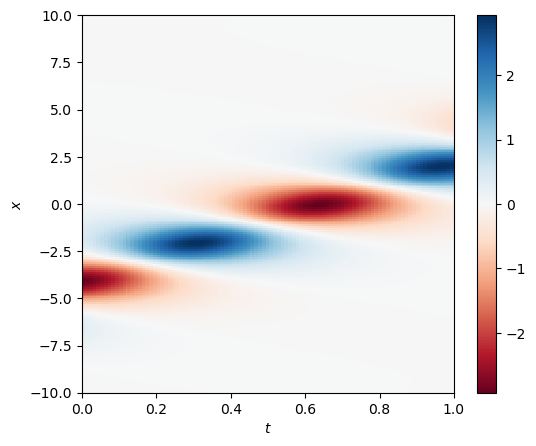

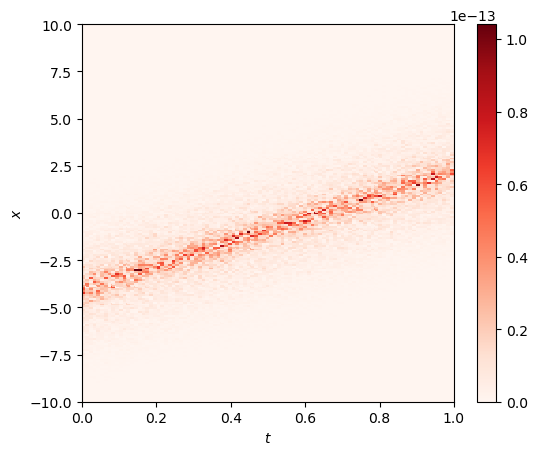

In [4]:
#domain:
x_0=-10
x_1=10
t_0=0
t_1=1
x_parts=200
t_parts=100
x=np.linspace(x_0,x_1,x_parts)
t=np.linspace(t_0,t_1,t_parts)
delta_x=x[1]-x[0]
delta_t=t[1]-t[0]
#equation and initial condition parameters:
a1 = 1
a2 = -1
a4 = -0.3
a6 = 0.1
b1 = 6
k_param = 1 #k_param must be 1
khi = 1
a_param = 0.5
x0_param = 4
theta0 = math.pi/3

A1_param = (2*khi*(a2-6*a4*(k_param**2) + 12*a4*k_param + 10*a4 + 75*a6*(k_param**4) + 150*a6*(k_param**2) + 91*a6)/b1)**0.5
C0_param = a1 + 2*a2*k_param + 8*a4*(k_param**3) + 96*a6*(k_param**5)
w_param = a1*k_param + a2*(k_param**2) - a2 + 3*a4*(k_param**4) - 6*a4*(k_param**2) - a4 + 35*a6*(k_param**6) - 75*a6*(k_param**4) - 15*a6*(k_param**2) - a6
a3 = -4*a4*k_param - 40*a6*(k_param**3)
a5 = -6*a6*k_param
b2 = -(24*a4*(khi**2) + 360*a6*(khi**2)*(k_param**2) + 840*a6*(khi**2))/(A1_param**4)
b3 = 720*a6*(khi**3)/(A1_param**6)
print(f"a1 = {a1:.3f}, a2 = {a2:.3f}, a3 = {a3:.3f}, a4 = {a4:.3f}, a5 = {a5:.3f}, a6 = {a6:.3f},\n b1 = {b1:.3f}, b2 = {b2:.3f}, b3 = {b3:.3f}")

def q(x,t):
    frac = A1_param/(a_param*np.exp(x-C0_param*t+x0_param) + khi/(4*a_param*np.exp(x-C0_param*t+x0_param)))
    u = frac*np.cos(k_param*x-w_param*t+theta0)
    v = frac*np.sin(k_param*x-w_param*t+theta0)
    return u,v

def q_tensor(x,t):
    frac = A1_param/(a_param*torch.exp(x-C0_param*t+x0_param) + khi/(4*a_param*torch.exp(x-C0_param*t+x0_param)))
    u = frac*torch.cos(k_param*x-w_param*t+theta0)
    v = frac*torch.sin(k_param*x-w_param*t+theta0)
    return u,v

##chart
x = np.linspace(x_0, x_1, x_parts)
t = np.linspace(t_0, t_1, t_parts)
X, T = np.meshgrid(x, t)
U, V = q(X,T)
Q_abs = (U**2 + V**2)**0.5

fig, ax = plt.subplots(1, 1, figsize=(6,5), dpi=100)
ax.set(xlabel='$t$', ylabel='$x$')
c = ax.pcolormesh(T, X, U, cmap='RdBu')
ax.axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=ax)

##analytical solution accuracy
X_tensor = torch.tensor(X, requires_grad=True)
T_tensor = torch.tensor(T, requires_grad=True)
u, v = q_tensor(X_tensor, T_tensor)
#real part of derivatives
u_t = torch.autograd.grad(u,T_tensor,grad_outputs=torch.ones_like(u),retain_graph=True,create_graph=True)[0]
u_x = torch.autograd.grad(u,X_tensor,grad_outputs=torch.ones_like(u),retain_graph=True,create_graph=True)[0]
u_xx = torch.autograd.grad(u_x,X_tensor,grad_outputs=torch.ones_like(u_x),retain_graph=True,create_graph=True)[0]
u_3x = torch.autograd.grad(u_xx,X_tensor,grad_outputs=torch.ones_like(u_xx),retain_graph=True,create_graph=True)[0]
u_4x = torch.autograd.grad(u_3x,X_tensor,grad_outputs=torch.ones_like(u_3x),retain_graph=True,create_graph=True)[0]
u_5x = torch.autograd.grad(u_4x,X_tensor,grad_outputs=torch.ones_like(u_4x),retain_graph=True,create_graph=True)[0]
u_6x = torch.autograd.grad(u_5x,X_tensor,grad_outputs=torch.ones_like(u_5x),retain_graph=True,create_graph=True)[0]
#complex part of derivatives
v_t = torch.autograd.grad(v,T_tensor,grad_outputs=torch.ones_like(v),retain_graph=True,create_graph=True)[0]
v_x = torch.autograd.grad(v,X_tensor,grad_outputs=torch.ones_like(v),retain_graph=True,create_graph=True)[0]
v_xx = torch.autograd.grad(v_x,X_tensor,grad_outputs=torch.ones_like(v_x),retain_graph=True,create_graph=True)[0]
v_3x = torch.autograd.grad(v_xx,X_tensor,grad_outputs=torch.ones_like(v_xx),retain_graph=True,create_graph=True)[0]
v_4x = torch.autograd.grad(v_3x,X_tensor,grad_outputs=torch.ones_like(v_3x),retain_graph=True,create_graph=True)[0]
v_5x = torch.autograd.grad(v_4x,X_tensor,grad_outputs=torch.ones_like(v_4x),retain_graph=True,create_graph=True)[0]
v_6x = torch.autograd.grad(v_5x,X_tensor,grad_outputs=torch.ones_like(v_5x),retain_graph=True,create_graph=True)[0]

#i*q_t + i*a1*q_x + a2*q_xx + i*a3*q_3x + a4*q_4x + i*a5*q_5x + a6*q_6x + q*(b1*|q|**2 + b2*|q|**4 + b3*|q|**6) = 0
Real_Loss = -v_t - a1*v_x + a2*u_xx - a3*v_3x + a4*u_4x - a5*v_5x + a6*u_6x + u*(b1*(u**2 + v**2) + b2*(u**2 + v**2)**2 + b3*(u**2 + v**2)**3)
Complex_Loss = u_t + a1*u_x + a2*v_xx + a3*u_3x + a4*v_4x + a5*u_5x + a6*v_6x + v*(b1*(u**2 + v**2) + b2*(u**2 + v**2)**2 + b3*(u**2 + v**2)**3)
Loss = (Real_Loss**2 + Complex_Loss**2)**0.5

fig, ax = plt.subplots(1, 1, figsize=(6,5), dpi=100)
ax.set(xlabel='$t$', ylabel='$x$')
c = ax.pcolormesh(T, X, Loss.detach().numpy(), cmap='Reds')
ax.axis([t_0, t_1, x_0, x_1])
fig.colorbar(c, ax=ax)

In [5]:
class SinActivation(torch.nn.Module):
    def __init__(self):
        super(SinActivation, self).__init__()
        return
    def forward(self, x):
        return torch.sin(x)

class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()

        self.depth = len(layers) - 1
        self.activation = SinActivation #custom activation function

        layer_list = list()
        for i in range(self.depth - 1):
            layer_list.append(('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1])))
            layer_list.append(('activation_%d' % i, self.activation()))
        layer_list.append(('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1])))
        layerDict = OrderedDict(layer_list)

        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
    def forward(self, x):
        out = self.layers(x)
        return out

class PhysicsInformedNN():
    def __init__(self, X_i, u, v, X_b, X_f, layers, lb, ub):
        
        #verbosity
        self.verbosity = 1000 #loss output frequency
        self.make_res_gif = True #makes gif with residual history
        #points generation options
        self.points_gen_method = "first" #"random"/first"/"second"/"third"
        self.points_gen_freq = 10 #points generation frequency
        #optimization options
        self.adam_steps = 10000
        self.lbfgs_steps = 10
        self.nncg_steps = 0
        self.adam_step_decay = 0.997
        self.lbfgs_step_decay = 0.990
        self.nncg_step_decay = 0.990
        self.decay_freq = 100
        #loss balancing options
        self.loss_bal_method = "none" #"none"/relobralo"
        self.bal_freq = 1 #loss rebalancing frequency
        self.lambda_i = 10/12
        self.lambda_b = 1/12
        self.lambda_f = 1/12
        self.extinction = 0.9 #extinction coefficient for ReLoBRaLo
        #causal training
        self.causal_loss = True
        self.epsilon = 0.1
        self.t_partition = 30 #number of parts in the [t_0, t_1] division
        
        #self.lb = torch.tensor(lb).float().to(device) #lower left corner of domain
        #self.ub = torch.tensor(ub).float().to(device) #upper right corner of domain
        self.lb = lb
        self.ub = ub
        self.x_i = torch.tensor(X_i[:, 0:1], requires_grad=True).float().to(device) #initial conditions: (x_i, t_i, u, v)
        self.t_i = torch.tensor(X_i[:, 1:2], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        self.v = torch.tensor(v).float().to(device)
        self.x_b = torch.tensor(X_b[:, 0:1], requires_grad=True).float().to(device) #boundary conditions: (x_b, t_b, 0, 0)
        self.t_b = torch.tensor(X_b[:, 1:2], requires_grad=True).float().to(device)
        if self.points_gen_method != "random" or self.make_res_gif: #grid of values for wise point generation or chart generation
            self.x_grid = torch.tensor(X_f[:,:,0].flatten()[:,np.newaxis], requires_grad=True).float().to(device)
            self.t_grid = torch.tensor(X_f[:,:,1].flatten()[:,np.newaxis], requires_grad=True).float().to(device)
            self.grid_shapes = X_f.shape
        self.x_f = torch.tensor((lb + (ub-lb)*lhs(2, N_f))[:, 0:1], requires_grad=True).float().to(device) #initial collocation points
        self.t_f = torch.tensor((lb + (ub-lb)*lhs(2, N_f))[:, 1:2], requires_grad=True).float().to(device)
        
        if self.make_res_gif:
            self.frames=[]
            self.snap_freq=(self.adam_steps+self.lbfgs_steps+self.nncg_steps)//100
        
        self.layers = layers
        self.dnn = DNN(layers).to(device)

        # optimizers
        self.adam = torch.optim.Adam(
          self.dnn.parameters(),
          lr=0.01,
          betas=(0.9, 0.999),
          eps=1e-08,
          weight_decay=0,
          amsgrad=False)
        
        self.lbfgs = torch.optim.LBFGS(
            self.dnn.parameters(),
            lr=1.0,
            max_iter=50000,
            max_eval=50000,
            history_size=50,
            tolerance_grad=1e-5,
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe")
        
        '''self.nncg = NysNewtonCG(
            self.dnn.parameters(),
            lr=0.005,
            rank=10,
            mu=1e-4,
            cg_tol=1e-5,
            cg_max_iters=100,
            line_search_fn='armijo')'''
        
        self.nncg_active = False
        self.first_nncg_iter = False
        self.grad_tuple = None
        self.train_finished = False
        self.iter = 0
        self.loss_hist = []
        self.iter_hist = []
        
        if self.loss_bal_method == "relobralo":
            u_init, v_init = self.net_uv(self.x_i, self.t_i)
            u_bound, v_bound = self.net_uv(self.x_b, self.t_b)
            f_u_pred, f_v_pred = self.net_f(self.x_f, self.t_f)
            #initial condition:
            self.L_in = torch.mean(((self.u - u_init)**2 + (self.v - v_init)**2)/2).item()
            #boundary conditions:
            u_x = torch.autograd.grad(u_bound,self.x_b,grad_outputs=torch.ones_like(u_bound),retain_graph=True,create_graph=True)[0]
            u_xx = torch.autograd.grad(u_x,self.x_b,grad_outputs=torch.ones_like(u_x),retain_graph=True,create_graph=True)[0]
            v_x = torch.autograd.grad(v_bound,self.x_b,grad_outputs=torch.ones_like(v_bound),retain_graph=True,create_graph=True)[0]
            v_xx = torch.autograd.grad(v_x,self.x_b,grad_outputs=torch.ones_like(v_x),retain_graph=True,create_graph=True)[0]
            self.L_b = torch.mean((u_bound**2 + u_x**2 + u_xx**2 + v_bound**2 + v_x**2 + v_xx**2)/6).item()
            #equation condition:
            self.L_f = torch.mean((f_u_pred**2 + f_v_pred**2)/2).item()
            self.L_in_0 = self.L_in
            self.L_b_0 = self.L_b
            self.L_f_0 = self.L_f

    def net_uv(self, x, t): #model output
        u = self.dnn(torch.cat([x, t], dim=1))[:,0:1]
        v = self.dnn(torch.cat([x, t], dim=1))[:,1:2]
        return u, v

    def net_f(self, x, t): #equation output
        u, v = self.net_uv(x, t)
        #real part of derivatives
        u_t = torch.autograd.grad(u,t,grad_outputs=torch.ones_like(u),retain_graph=True,create_graph=True)[0]
        u_x = torch.autograd.grad(u,x,grad_outputs=torch.ones_like(u),retain_graph=True,create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x,x,grad_outputs=torch.ones_like(u_x),retain_graph=True,create_graph=True)[0]
        u_3x = torch.autograd.grad(u_xx,x,grad_outputs=torch.ones_like(u_xx),retain_graph=True,create_graph=True)[0]
        u_4x = torch.autograd.grad(u_3x,x,grad_outputs=torch.ones_like(u_3x),retain_graph=True,create_graph=True)[0]
        u_5x = torch.autograd.grad(u_4x,x,grad_outputs=torch.ones_like(u_4x),retain_graph=True,create_graph=True)[0]
        u_6x = torch.autograd.grad(u_5x,x,grad_outputs=torch.ones_like(u_5x),retain_graph=True,create_graph=True)[0]
        #complex part of derivatives
        v_t = torch.autograd.grad(v,t,grad_outputs=torch.ones_like(v),retain_graph=True,create_graph=True)[0]
        v_x = torch.autograd.grad(v,x,grad_outputs=torch.ones_like(v),retain_graph=True,create_graph=True)[0]
        v_xx = torch.autograd.grad(v_x,x,grad_outputs=torch.ones_like(v_x),retain_graph=True,create_graph=True)[0]
        v_3x = torch.autograd.grad(v_xx,x,grad_outputs=torch.ones_like(v_xx),retain_graph=True,create_graph=True)[0]
        v_4x = torch.autograd.grad(v_3x,x,grad_outputs=torch.ones_like(v_3x),retain_graph=True,create_graph=True)[0]
        v_5x = torch.autograd.grad(v_4x,x,grad_outputs=torch.ones_like(v_4x),retain_graph=True,create_graph=True)[0]
        v_6x = torch.autograd.grad(v_5x,x,grad_outputs=torch.ones_like(v_5x),retain_graph=True,create_graph=True)[0]
        f_u = -v_t - a1*v_x + a2*u_xx - a3*v_3x + a4*u_4x - a5*v_5x + a6*u_6x + u*(b1*(u**2 + v**2) + b2*(u**2 + v**2)**2 + b3*(u**2 + v**2)**3)
        f_v = u_t + a1*u_x + a2*v_xx + a3*u_3x + a4*v_4x + a5*u_5x + a6*v_6x + v*(b1*(u**2 + v**2) + b2*(u**2 + v**2)**2 + b3*(u**2 + v**2)**3)
        return f_u, f_v

    def loss_func(self):
        self.adam.zero_grad()
        self.lbfgs.zero_grad()
        #self.nncg.zero_grad()

        u_init, v_init = self.net_uv(self.x_i, self.t_i)
        u_bound, v_bound = self.net_uv(self.x_b, self.t_b)
        f_u_pred, f_v_pred = self.net_f(self.x_f, self.t_f)
        #initial condition:
        loss_i = torch.mean(((self.u - u_init)**2 + (self.v - v_init)**2)/2)
        #boundary conditions:
        u_x = torch.autograd.grad(u_bound,self.x_b,grad_outputs=torch.ones_like(u_bound),retain_graph=True,create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x,self.x_b,grad_outputs=torch.ones_like(u_x),retain_graph=True,create_graph=True)[0]
        v_x = torch.autograd.grad(v_bound,self.x_b,grad_outputs=torch.ones_like(v_bound),retain_graph=True,create_graph=True)[0]
        v_xx = torch.autograd.grad(v_x,self.x_b,grad_outputs=torch.ones_like(v_x),retain_graph=True,create_graph=True)[0]
        loss_b = torch.mean((u_bound**2 + u_x**2 + u_xx**2 + v_bound**2 + v_x**2 + v_xx**2)/6)
        #equation condition:
        loss_f = torch.mean((f_u_pred**2 + f_v_pred**2)/2)
        if self.causal_loss == True and self.train_finished == False and loss_f<1: #last condition implies protection against loss_f spikes
            residuals = (f_u_pred**2 + f_v_pred**2)/2
            t_interval = (self.ub[1] - self.lb[1])/self.t_partition
            loss_f=0
            sum_residuals=0
            sum_w=0
            for i in range(self.t_partition): #calculating loss_f=sum(w_i*loss_f_i) according to causal training
                t_l=self.lb[1]+i*t_interval
                t_r=t_l+t_interval
                current_residuals=residuals[torch.where((self.t_f>=t_l) & (self.t_f<t_r))]
                sum_residuals+=torch.mean(current_residuals).item()
                current_w=math.exp(-self.epsilon*sum_residuals)
                sum_w+=current_w
                loss_f+=torch.mean(current_residuals)*current_w
            loss_f=loss_f/sum_w
            
        #loss evaluation for trained PINN
        if self.train_finished == True:
            loss = self.lambda_i*loss_i + self.lambda_b*loss_b + self.lambda_f*loss_f
            return loss
        
        if self.loss_bal_method == "relobralo" and self.iter%self.bal_freq == 0:
            L_in_prev = self.L_in
            L_b_prev = self.L_b
            L_f_prev = self.L_f
            self.L_in = loss_i.item()
            self.L_b = loss_b.item()
            self.L_f = loss_f.item()
            random_lookback = np.random.random()
            if self.L_f/self.L_f_0<1 and self.L_f/L_f_prev<1: #protection against loss_f spikes
                lambda_i_0 = math.exp(self.L_in/self.L_in_0)/(math.exp(self.L_in/self.L_in_0) + math.exp(self.L_b/self.L_b_0) + math.exp(self.L_f/self.L_f_0))
                lambda_b_0 = math.exp(self.L_b/self.L_b_0)/(math.exp(self.L_in/self.L_in_0) + math.exp(self.L_b/self.L_b_0) + math.exp(self.L_f/self.L_f_0))
                lambda_f_0 = math.exp(self.L_f/self.L_f_0)/(math.exp(self.L_in/self.L_in_0) + math.exp(self.L_b/self.L_b_0) + math.exp(self.L_f/self.L_f_0))
                lambda_i_prev = math.exp(self.L_in/L_in_prev)/(math.exp(self.L_in/L_in_prev) + math.exp(self.L_b/L_b_prev) + math.exp(self.L_f/L_f_prev))
                lambda_b_prev = math.exp(self.L_b/L_b_prev)/(math.exp(self.L_in/L_in_prev) + math.exp(self.L_b/L_b_prev) + math.exp(self.L_f/L_f_prev))
                lambda_f_prev = math.exp(self.L_f/L_f_prev)/(math.exp(self.L_in/L_in_prev) + math.exp(self.L_b/L_b_prev) + math.exp(self.L_f/L_f_prev))
                self.lambda_i = self.extinction*(random_lookback*self.lambda_i + (1-random_lookback)*lambda_i_0) + (1-self.extinction)*lambda_i_prev
                self.lambda_b = self.extinction*(random_lookback*self.lambda_b + (1-random_lookback)*lambda_b_0) + (1-self.extinction)*lambda_b_prev
                self.lambda_f = self.extinction*(random_lookback*self.lambda_f + (1-random_lookback)*lambda_f_0) + (1-self.extinction)*lambda_f_prev
        
        loss = self.lambda_i*loss_i + self.lambda_b*loss_b + self.lambda_f*loss_f
        
        self.iter += 1
        self.loss_hist.append(loss.item())
        self.iter_hist.append(self.iter)

        if self.iter % self.verbosity == 0:
            print('Iter %d, Loss: %.3e, Loss_i: %.2e, Loss_b: %.2e, Loss_f: %.2e' % (self.iter, loss.item(), loss_i.item(), loss_b.item(), loss_f.item()))
        if self.make_res_gif and self.iter%self.snap_freq==0:
            f_u_pred, f_v_pred = self.net_f(self.x_grid, self.t_grid)
            residual = ((f_u_pred**2 + f_v_pred**2)**0.5).detach().cpu().numpy().reshape((self.grid_shapes[0],self.grid_shapes[1]))
            x_grid=self.x_grid.detach().cpu().numpy().reshape((self.grid_shapes[0],self.grid_shapes[1]))
            t_grid=self.t_grid.detach().cpu().numpy().reshape((self.grid_shapes[0],self.grid_shapes[1]))
            fig, ax = plt.subplots()
            c = ax.pcolormesh(t_grid, x_grid, residual, cmap='Reds', vmin=0, vmax=0.1)
            ax.set_title(f'iter={self.iter}')
            ax.axis([t_0, t_1, x_0, x_1])
            fig.colorbar(c, ax=ax)
            plt.savefig(f'frames/capture_{self.iter}.png')
            plt.close()
            frame = Image.open(f'frames/capture_{self.iter}.png')
            self.frames.append(frame)

        if self.iter % self.points_gen_freq == 0: #generating new points
            lambda_1 = 0.005
            lambda_2 = 0.01
            if self.points_gen_method == "random": #random points choice
                random_points = self.lb + (self.ub-self.lb)*lhs(2, N_f)
                self.x_f = torch.tensor(random_points[:, 0:1], requires_grad=True).float().to(device)
                self.t_f = torch.tensor(random_points[:, 1:2], requires_grad=True).float().to(device)
            else:
                f_u_pred, f_v_pred = self.net_f(self.x_grid, self.t_grid)
                residual = ((f_u_pred**2 + f_v_pred**2)**0.5).detach().cpu().numpy()
                max_residual = np.max(residual)
                min_residual = np.min(residual)
                nu_1 = (residual - min_residual)/(max_residual - min_residual)
                if self.points_gen_method == "first": probability = nu_1
                if self.points_gen_method == "second": probability = nu_1 + lambda_1
                if self.points_gen_method == "third":
                    u_pred, v_pred = self.net_uv(self.x_grid, self.t_grid)
                    sum_abs = (torch.abs(u_pred) + torch.abs(v_pred)).detach().cpu().numpy()
                    max_sum_abs = np.max(sum_abs)
                    min_sum_abs = np.min(sum_abs)
                    nu_2 = (sum_abs - min_sum_abs)/(max_sum_abs - min_sum_abs)
                    nu_3 = (nu_1 + nu_2)/2
                    probability = nu_3 + lambda_2*np.max(nu_3)
                norm_probability = probability[:,0]/np.sum(probability)
                inds = np.random.choice(self.grid_shapes[0]*self.grid_shapes[1], N_f, replace=False, p=norm_probability)
                self.x_f = torch.clone(self.x_grid[inds,:])
                self.t_f = torch.clone(self.t_grid[inds,:])

        if self.nncg_active == True:
            self.grad_tuple = torch.autograd.grad(loss, self.dnn.parameters(), create_graph=True)
            if self.first_nncg_iter == True:
                self.nncg.update_preconditioner(self.grad_tuple)
                self.first_nncg_iter = False
            return loss, self.grad_tuple
        else:
            loss.backward(retain_graph=True)
            return loss

    def train(self):        
        if self.make_res_gif and not os.path.exists('./frames'):
            os.mkdir('./frames')
        lbfgs_iterations=0
        nncg_iterations=0
        self.train_finished = False
        if self.causal_loss == True:
            print(f'Training started with {self.points_gen_method} points generation method, {self.loss_bal_method} loss balancing and causal loss')
        else:
            print(f'Training started with {self.points_gen_method} points generation method and {self.loss_bal_method} loss balancing')
        print(f'{self.adam_steps} steps of ADAM:')
        self.dnn.train()
        for i in range(self.adam_steps):
            self.adam.step(self.loss_func)
            if i % self.decay_freq == 0: self.adam.param_groups[0]['lr'] = self.adam_step_decay*self.adam.param_groups[0]['lr']
        if self.lbfgs_steps != 0:
            print(f'{self.lbfgs_steps} steps of LBFGS:')
            for i in range(self.lbfgs_steps):
                self.lbfgs.step(self.loss_func)
                if i % self.decay_freq == 0: self.lbfgs.param_groups[0]['lr'] = self.lbfgs_step_decay*self.lbfgs.param_groups[0]['lr']
            lbfgs_iterations = self.iter-self.adam_steps
        if self.nncg_steps != 0:
            print(f'{self.nncg_steps} steps of NNCG:')
            self.nncg_active = True
            for i in range(self.nncg_steps):
                self.first_nncg_iter = True
                self.nncg.step(self.loss_func)
                if i % self.decay_freq == 0: self.nncg.param_groups[0]['lr'] = self.nncg_step_decay*self.nncg.param_groups[0]['lr']
            nncg_iterations = self.iter-lbfgs_iterations-self.adam_steps
        print(f'Total iterations: {self.adam_steps} + {lbfgs_iterations} + {nncg_iterations}')
        if self.make_res_gif:
            self.frames[0].save('train_process.gif', save_all=True, append_images=self.frames[1:],optimize=True,duration=100,loop=0)
            self.frames=[]
            shutil.rmtree('./frames')
        self.train_finished = True
        self.lambda_i = 10/12
        self.lambda_b = 1/12
        self.lambda_f = 1/12

    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)
        self.dnn.eval()
        u, v = self.net_uv(x, t)
        f_u, f_v = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        v = v.detach().cpu().numpy()
        f_u = f_u.detach().cpu().numpy()
        f_v = f_v.detach().cpu().numpy()
        return u, v, f_u, f_v
    
    def train_hist(self, logscale=True, step=1):
        plt.plot(np.array(self.iter_hist)[::step], np.array(self.loss_hist)[::step], color = "blue")
        plt.figtext(0.15, -0.05, f'Final loss: {model.loss_func()}', weight='regular', fontsize='9')
        #plt.ylim(0,5e-3)
        if logscale:
            plt.yscale("log")
        plt.title('Loss(iter)')
        return plt.show()
    
    def plot_residual(self, X, T):
        X_tensor = torch.tensor(X.flatten()[:,np.newaxis], requires_grad=True).float()
        T_tensor = torch.tensor(T.flatten()[:,np.newaxis], requires_grad=True).float()
        Real_Loss, Complex_Loss = self.net_f(X_tensor.to(device), T_tensor.to(device))
        flatten_Loss = (Real_Loss**2 + Complex_Loss**2)**0.5
        Loss = torch.reshape(flatten_Loss,(X.shape[0],X.shape[1])).cpu().detach().numpy()
        fig, ax = plt.subplots(1, 1, figsize=(6,5), dpi=100)
        plt.title('Residual(t,x)')
        ax.set(xlabel='$t$', ylabel='$x$')
        c = ax.pcolormesh(T, X, Loss, cmap='Reds')
        ax.axis([T.min(), T.max(), X.min(), X.max()])
        fig.colorbar(c, ax=ax)
        return plt.show()

In [6]:
def plot_comparison(X, T, Q_calc, Q_truth, savefig=False):
    fig, axs = plt.subplots(3, 3, figsize=(21,10), dpi=300)
    for ax in axs.flat:
        ax.set(xlabel='$t$', ylabel='$x$')
        ax.label_outer()      

    U_truth=np.real(Q_truth)
    V_truth=np.imag(Q_truth)
    Q_abs_truth=np.abs(Q_truth)
    q_abs_min, q_abs_max = 0, np.abs(Q_abs_truth).max()
    c = axs[0,0].pcolormesh(T, X, Q_abs_truth, cmap='BuPu', vmin=q_abs_min, vmax=q_abs_max)
    axs[0,0].set_title('$|q_{truth}|(x,t)$')
    axs[0,0].axis([t_0, t_1, x_0, x_1])
    fig.colorbar(c, ax=axs[0,0])
    u_min, u_max = -np.abs(U_truth).max(), np.abs(U_truth).max()
    c = axs[0,1].pcolormesh(T, X, U_truth, cmap='RdBu', vmin=u_min, vmax=u_max)
    axs[0,1].set_title('$u_{truth}(x,t)$')
    axs[0,1].axis([t_0, t_1, x_0, x_1])
    fig.colorbar(c, ax=axs[0,1])
    c = axs[0,2].pcolormesh(T, X, V_truth, cmap='RdBu', vmin=u_min, vmax=u_max)
    axs[0,2].set_title('$v_{truth}(x,t)$')
    axs[0,2].axis([t_0, t_1, x_0, x_1])
    fig.colorbar(c, ax=axs[0,2])

    U_calc=np.real(Q_calc)
    V_calc=np.imag(Q_calc)
    Q_abs_calc=np.abs(Q_calc)
    #q_abs_min, q_abs_max = 0, np.abs(Q_abs_calc).max()
    c = axs[1,0].pcolormesh(T, X, Q_abs_calc, cmap='BuPu', vmin=q_abs_min, vmax=q_abs_max)
    axs[1,0].set_title('$|q_{pred}|(x,t)$')
    axs[1,0].axis([t_0, t_1, x_0, x_1])
    fig.colorbar(c, ax=axs[1,0])
    #u_min, u_max = -np.abs(U_calc).max(), np.abs(U_calc).max()
    c = axs[1,1].pcolormesh(T, X, U_calc, cmap='RdBu', vmin=u_min, vmax=u_max)
    axs[1,1].set_title('$u_{pred}(x,t)$')
    axs[1,1].axis([t_0, t_1, x_0, x_1])
    fig.colorbar(c, ax=axs[1,1])
    c = axs[1,2].pcolormesh(T, X, V_calc, cmap='RdBu', vmin=u_min, vmax=u_max)
    axs[1,2].set_title('$v_{pred}(x,t)$')
    axs[1,2].axis([t_0, t_1, x_0, x_1])
    fig.colorbar(c, ax=axs[1,2])
    
    U_diff = np.abs(U_truth-U_calc)
    V_diff = np.abs(U_truth-U_calc)
    Q_abs_diff = np.abs(Q_abs_truth-Q_abs_calc)
    q_abs_min, q_abs_max = 0, np.abs(Q_abs_diff).max()
    c = axs[2,0].pcolormesh(T, X, Q_abs_diff, cmap='Reds', vmin=q_abs_min, vmax=q_abs_max)
    axs[2,0].set_title('$||q_{truth}|-|q_{pred}||(x,t)$')
    axs[2,0].axis([t_0, t_1, x_0, x_1])
    fig.colorbar(c, ax=axs[2,0])
    u_min, u_max = U_diff.min(), U_diff.max()
    c = axs[2,1].pcolormesh(T, X, U_diff, cmap='Reds', vmin=u_min, vmax=u_max)
    axs[2,1].set_title('$|u_{truth}-u_{pred}|(x,t)$')
    axs[2,1].axis([t_0, t_1, x_0, x_1])
    fig.colorbar(c, ax=axs[2,1])
    c = axs[2,2].pcolormesh(T, X, V_diff, cmap='Reds', vmin=u_min, vmax=u_max)
    axs[2,2].set_title('$|v_{truth}-v_{pred}|(x,t)$')
    axs[2,2].axis([t_0, t_1, x_0, x_1])
    fig.colorbar(c, ax=axs[2,2])

    mse_q = np.mean((Q_abs_truth.flatten() - Q_abs_calc.flatten())**2)
    rel_h = np.linalg.norm(Q_abs_truth.flatten() - Q_abs_calc.flatten(), 2)/np.linalg.norm(Q_abs_truth.flatten(), 2)
    plt.figtext(0.12, 0.00, f'MSE_q: {mse_q:.3e}, Rel_h: {rel_h:.3e}', weight='regular', fontsize='12')
    
    if savefig:
        plt.savefig("comparison.png")
    return plt.show()

In [7]:
N_u = 200 # points on boundaries
N_f = 5000 # collocation points
layers = [2, 100, 100, 100, 2] #network topology
x = np.linspace(x_0, x_1, x_parts)
t = np.linspace(t_0, t_1, t_parts)
X, T = np.meshgrid(x, t)

Exact_q=q(X,T)[0] + 1j*q(X,T)[1]
Exact_u=np.real(Exact_q)
Exact_v=np.imag(Exact_q)
Exact_q_abs = np.abs(Exact_q)

x_star = X.flatten()[:,None]
t_star = T.flatten()[:,None]
X_star = np.hstack((x_star, t_star))
u_star = Exact_u.flatten()[:,None]
v_star = Exact_v.flatten()[:,None]
q_abs_star = Exact_q_abs.flatten()[:,None]

# edge points
lb = X_star.min(0)
ub = X_star.max(0)
# initial conditions
xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T)) #(x,t_0)
uu1 = Exact_u[0:1,:].T
vv1 = Exact_v[0:1,:].T
# boundary conditions
xx2 = np.hstack((X[:,0:1], T[:,0:1])) #(x_0,t)
xx3 = np.hstack((X[:,-1:], T[:,-1:])) #(x_1,t)
#xx4 = np.hstack((X[-1:,:].T, T[-1:,:].T)) #(x,t_1)
X_uv_train = xx1
u_train = uu1
v_train = vv1
X_b_train = np.vstack([xx2, xx3])
X_f_train = lb + (ub-lb)*lhs(2, N_f)
X_f_train = np.vstack((X_f_train, np.vstack([xx1, xx2, xx3])))
idx = np.random.choice(X_uv_train.shape[0], N_u, replace=False)
X_uv_train = X_uv_train[idx,:]
u_train = u_train[idx,:]
v_train = v_train[idx,:]

#grid for wise points generation
X_g, T_g = np.meshgrid(np.linspace(x_0, x_1, 2*x_parts//3), np.linspace(t_0, t_1, 2*t_parts//3))
X_grid = np.stack((X_g, T_g),axis=2)

model = PhysicsInformedNN(X_uv_train, u_train, v_train, X_b_train, X_grid, layers, lb, ub)

In [8]:
%%time
model.train()

Training started with first points generation method, none loss balancing and causal loss
10000 steps of ADAM:


<ipython-input-5-ff59da5e4a0b>:234: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(t_grid, x_grid, residual, cmap='Reds', vmin=0, vmax=0.1)


Iter 1000, Loss: 1.407e-02, Loss_i: 4.74e-03, Loss_b: 3.10e-04, Loss_f: 1.21e-01
Iter 2000, Loss: 1.079e-02, Loss_i: 3.52e-03, Loss_b: 4.85e-04, Loss_f: 9.39e-02
Iter 3000, Loss: 1.013e-02, Loss_i: 3.58e-03, Loss_b: 1.96e-04, Loss_f: 8.55e-02
Iter 4000, Loss: 2.029e-02, Loss_i: 5.55e-03, Loss_b: 1.12e-03, Loss_f: 1.87e-01
Iter 5000, Loss: 6.878e-03, Loss_i: 2.31e-03, Loss_b: 3.36e-04, Loss_f: 5.91e-02
Iter 6000, Loss: 3.639e-03, Loss_i: 1.42e-03, Loss_b: 2.25e-04, Loss_f: 2.92e-02
Iter 7000, Loss: 5.812e-03, Loss_i: 1.83e-03, Loss_b: 2.17e-04, Loss_f: 5.13e-02
Iter 8000, Loss: 3.434e-03, Loss_i: 1.34e-03, Loss_b: 2.16e-04, Loss_f: 2.76e-02
Iter 9000, Loss: 2.676e-03, Loss_i: 1.12e-03, Loss_b: 1.72e-04, Loss_f: 2.07e-02
Iter 10000, Loss: 2.379e-02, Loss_i: 7.18e-03, Loss_b: 3.38e-04, Loss_f: 2.13e-01
10 steps of LBFGS:
Total iterations: 10000 + 205 + 0
CPU times: user 49min 15s, sys: 21.4 s, total: 49min 36s
Wall time: 49min 31s


In [9]:
torch.save(model, f'ch_model.pth')
#model = torch.load(f'causal_big_model.pth', map_location=device)
u_pred, v_pred, f_u_pred, f_v_pred = model.predict(X_star)

/opt/conda/lib/python3.8/site-packages/torch/serialization.py:359: UserWarning: Couldn't retrieve source code for container of type DNN. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "
/opt/conda/lib/python3.8/site-packages/torch/serialization.py:359: UserWarning: Couldn't retrieve source code for container of type SinActivation. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "


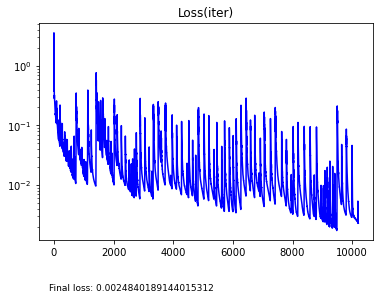

In [10]:
model.train_hist()

<ipython-input-5-ff59da5e4a0b>:350: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(T, X, Loss, cmap='Reds')


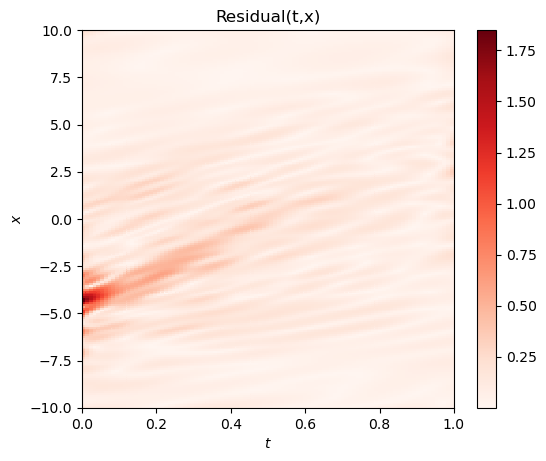

In [11]:
model.plot_residual(X, T)

<ipython-input-6-35434d9e9290>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = axs[0,0].pcolormesh(T, X, Q_abs_truth, cmap='BuPu', vmin=q_abs_min, vmax=q_abs_max)
<ipython-input-6-35434d9e9290>:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = axs[0,1].pcolormesh(T, X, U_truth, cmap='RdBu', vmin=u_min, vmax=u_max)
<ipython-input-6-35434d9e9290>:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated

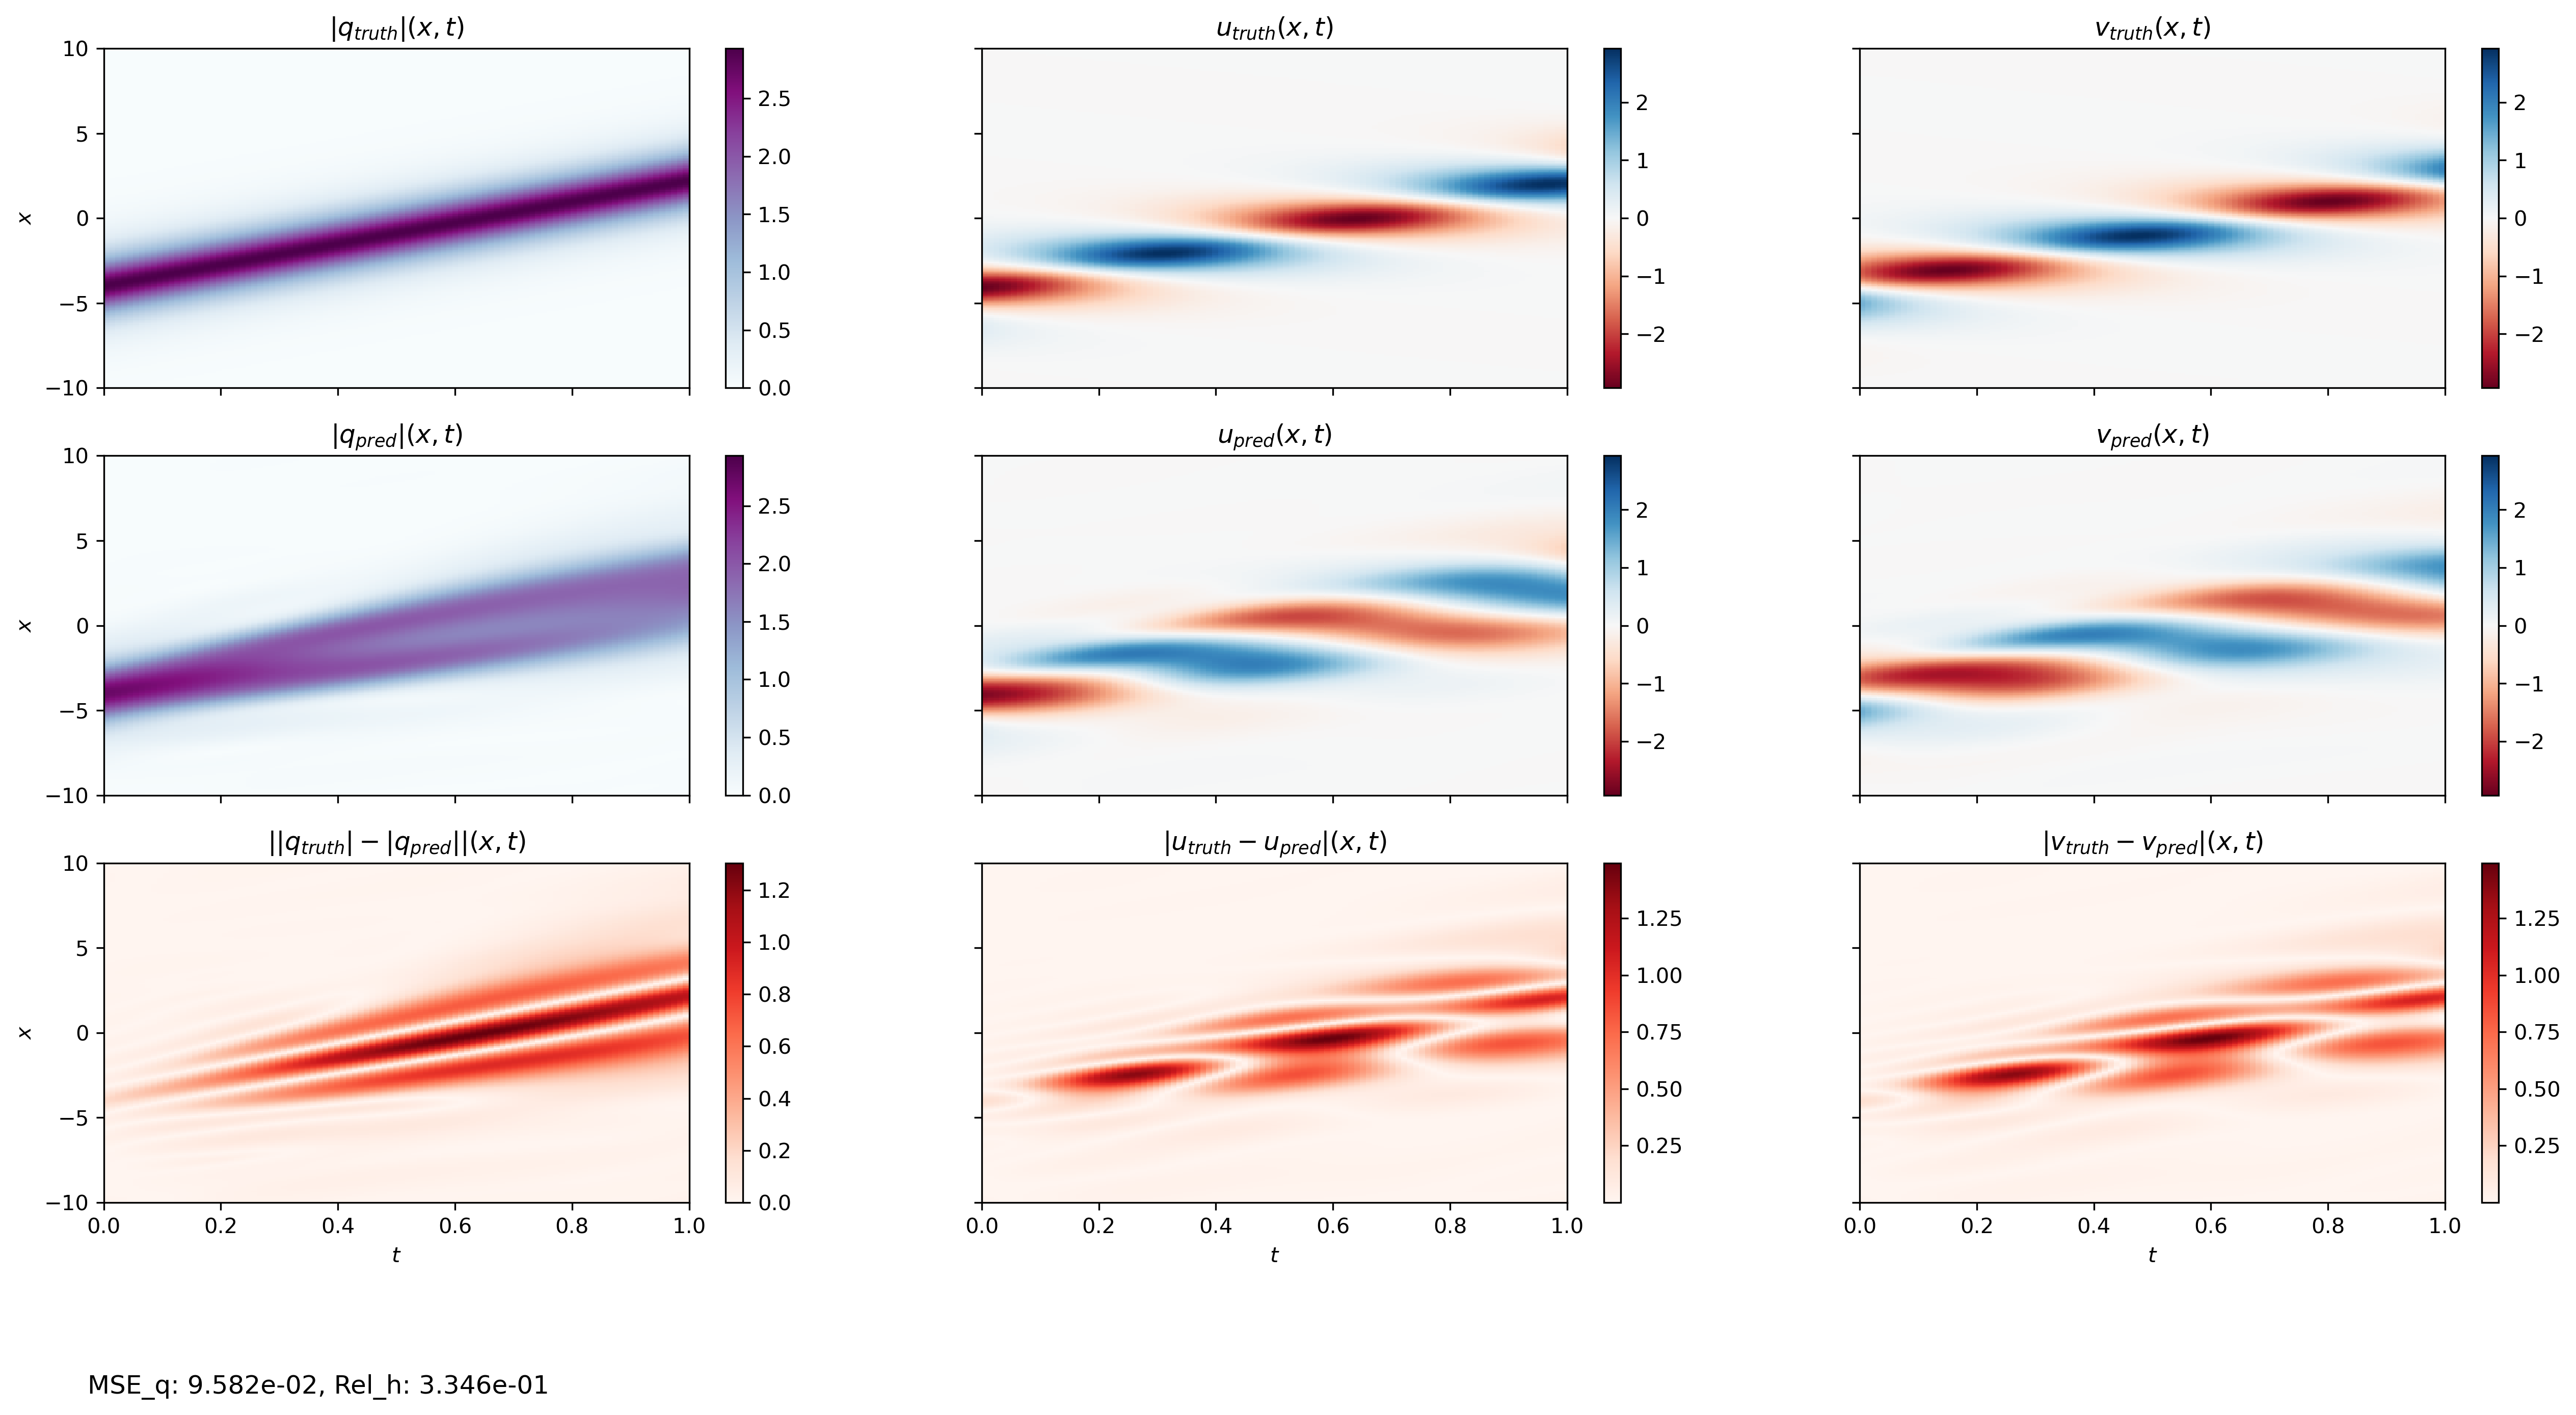

In [12]:
Q_pred=u_pred.reshape((t_parts, x_parts)) + 1j*v_pred.reshape((t_parts, x_parts))
Q_truth=q(X,T)[0]+1j*q(X,T)[1]
plot_comparison(X, T, Q_pred, Q_truth)

In [13]:
q_abs_pred = (u_pred**2 + v_pred**2)**0.5
data = pd.DataFrame({'x': x_star[:,0],
                     't': t_star[:,0],
                     'true_u': u_star[:,0],
                     'true_v': v_star[:,0],
                     'true_h': q_abs_star[:,0],
                     'pred_u': u_pred[:,0],
                     'pred_v': v_pred[:,0],
                     'pred_h': q_abs_pred[:,0]})
data.to_csv('ch_data.csv', index=False)